In [96]:
%matplotlib notebook
import sys
import scipy.misc
import scipy.signal
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import gridRing


 # Kalman filter


In [98]:
def KalmanFilter (H, F, x_old, P_old, meas, R, Q):

    y_err = (np.matrix(meas) - np.matmul(H, x_old.T))
    S = np.matmul(np.matmul(H,P_old),H.T) + np.matrix(R) # (1,4) (4,4) (4,1) + (1,1)
    K = np.matmul(np.matmul(P_old,H.T),np.linalg.inv(S)) # (4,4) (4,1) (1,1)

    I = F # (4,4)
    x_new = x_old + (K * y_err).T # (1,4) = (1,4) + ((4,1)(1,1)).T
    
    P_new = np.matmul((I - np.matmul(K, H)), P_old) # (4,4) = ((4,4) - (4,1)(1,4)) (4,4)

    x_old = x_new # (1,4)

    P_old = np.matmul(np.matmul(F,P_new),F.T) + Q

    return x_old, P_old

initialize variables:

In [99]:
plot = True
T = 3
N = 100
n_var = 0.4

Po,Pall = gridRing(4)
poles = [Pall[0], Pall[3]]

Drr = abs(Po)
Dtheta = np.angle(Po)
WVar = []

# generate dictionary
for i in range(0, N):  # matrix 8
    W1 = (Drr**i) * mt.cos(i * Dtheta)
    W2 = (-Drr**i) * mt.cos(i * Dtheta)
    W3 = (Drr**i) * mt.sin(i * Dtheta)
    W4 = (-Drr**i) * mt.sin(i * Dtheta)
    W = np.concatenate((W1, W2, W3, W4), 0)
    W = np.expand_dims(W, axis=0)
    WVar.append(W)
dic = np.concatenate((WVar), 0)

In [100]:
# system generation
syst = scipy.signal.lti([], Pall, 1) # Pall or poles ?
ir = scipy.signal.impulse(syst, N=N)
ir = -np.flipud(ir[1])

# observed (measured) input: y
y = ir + np.random.normal(0,n_var,N) * ir

# Filtering

In [101]:
count = 0
result = []
for n in range(3,N):
    
    H = dic[n,:]
    meas = y[n]

    # Initial conditions
    
    if count == 0:
        H = dic[0:T,:] # 3 first rows of the dictionary (T=3)
        x = np.linalg.lstsq(H, ir[0:3], rcond=None)[0] # least squares solution to obtain c
        f_meas = np.matmul(H,x) # first measurements
        result = f_meas.tolist() 
        
        H = dic[T, :] # 4th row of D is the input H
        meas = ir[T] # 4th row of the TRUE signal is the input
        # meas = y[T]
        R = 0.01 ** 2 # measurement noise
        Hinv = np.linalg.lstsq(np.matrix(x), np.matrix(meas), rcond=None)[0]
        Q = np.matmul(np.matmul(Hinv, np.matrix(R)), Hinv.T) # movement noise 
        P = Q
        P = np.zeros([4,4])
        
        count +=1

    F = np.eye(4) # transfer function
    
    H = np.expand_dims(H, axis=0)

    x,P = KalmanFilter(H, F, x, P, meas, R, Q) # Filtering
    
    result.append(np.asscalar(np.matmul(np.expand_dims(dic[n,:],axis=0), x.T))) # append results to list

<IPython.core.display.Javascript object>


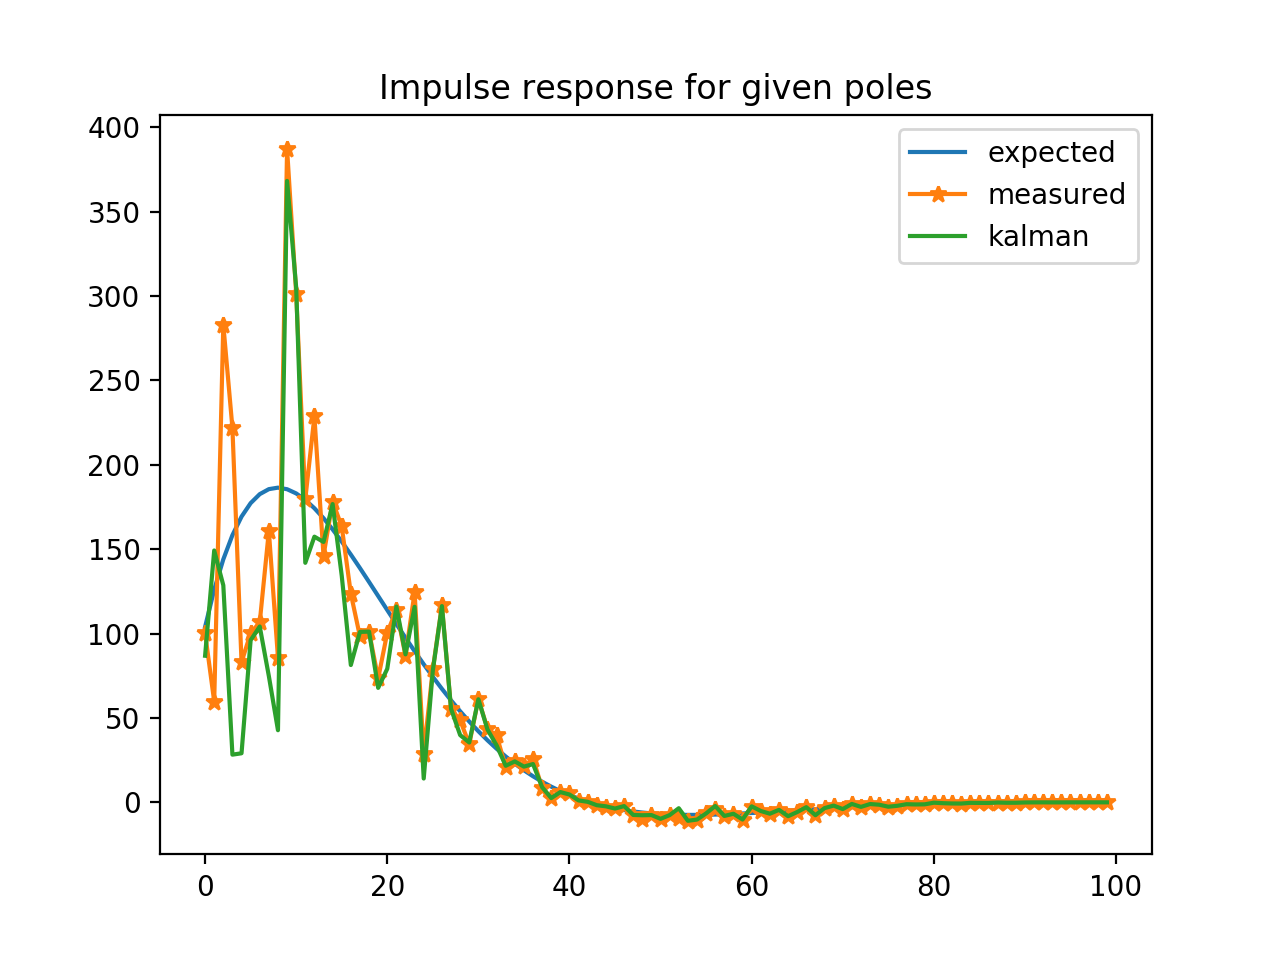

In [102]:
if plot:
    plt1, = plt.plot(ir, label='expected')
    plt2, = plt.plot(y, label='measured' ,marker = '*')
    plt3, = plt.plot(result, label='kalman')
    plt.legend(handles = [plt1, plt2, plt3])
    plt.title('Impulse response for given poles')
    # plt.savefig('IR2.png')
    
    plt.show();
